In [11]:
%matplotlib inline

import warnings
#warnings.filterwarnings('ignore')
import pickle, os, glob
from EEG.info import info_exp
from EEG.converter import converter_mne
import mne
import numpy as np
import sys

In [12]:
root = "C:\\eeg\\01exp\\"
name = "20161129_DBS_001"

def load(path,name):
    with open(path + '/' + name, 'rb') as input:
        data = pickle.load(input)
        return data

In [13]:
test = load(root + name,'exp_data_aligned_start_150.cls')

In [14]:
test.getinfo()

Experiment status:  True ; Num tests:  12
Align status:  True
Respondent name:  Ольга Ветрова
Description: Эксперимент с обратной связью
Labels_names: [ удалено, отдых, левая, правая ]
Frequency: 1000
Count train activities:  45
Count tests activities: [ 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30 ]
Time of activity: 4600
Type_chanels: eeg  Montage: standard_1005
------------------------------------------------------------------
Chanels_names:
------------------------------------------------------------------
FC5        FT7        FC3        FCz        FC4        FT8       
T3         C3         Cz         T4         C4        
TP7        CP3        CPz        CP4        TP8       
FC1        FC2        FC6        P4         C5        
C1         C2         C6         P3         CP5       
CP1        CP2        CP6        POz       
------------------------------------------------------------------
List tests
------------------------------------------------------------------
2016112

In [15]:
data  = converter_mne(test)
epochs = data.train_epochs()
raw = data.train_raw()
raw.filter(10,16,phase='zero',filter_length='auto', fir_window='hamming',l_trans_bandwidth='auto', h_trans_bandwidth='auto')

<RawArray  |  None, n_channels x n_times : 30 x 207000 (207.0 sec), ~47.4 MB, data loaded>

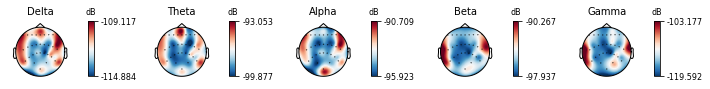

Figure(720x108)


In [16]:
print epochs.plot_psd_topomap()
picks = mne.pick_types(info=data.mne_info(), meg=False, eeg=True, misc=False)

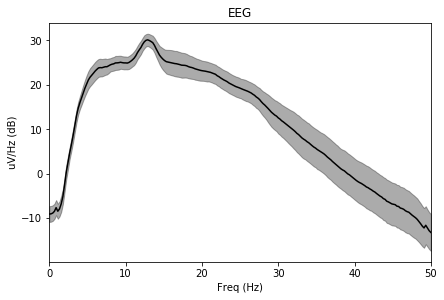

Figure(432x288)


In [17]:
print epochs.plot_psd(area_mode='std', tmax=4.499,fmax=50.)

In [18]:
from mne.time_frequency import psd_multitaper
f, ax = plt.subplots(figsize=(20, 10))
psds, freqs = psd_multitaper(raw, low_bias=True, tmax=4.499,
                              fmax=50., proj=True, picks=picks,
                              n_jobs=1)
psds = 10 * np.log10(psds)
psds_mean = psds.mean(0)
psds_std = psds.std(0)

ax.grid(True)
ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)
ax.set(title='Multitaper PSD', xlabel='Frequency',
       ylabel='Power Spectral Density (dB)')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
mne.set_log_level(verbose = "ERROR")
# get test list
test_list = []
for i in range(0,data.num_tests):
    epochs_test = data.test_epochs(i)
    Y_test = epochs_test.events[:,-1]
    X_test = epochs_test.get_data()
    test_list.append({'Y_test':Y_test,'X_test':X_test})

In [ ]:
import scipy.signal as spsig
import matplotlib.pyplot as plt

def data_prep(data, sfreq, fmin, fmax):
    [b_high, a_high] = spsig.butter(4, float(fmin) / (sfreq / 2), 'high')
    [b_low, a_low] = spsig.butter(4, float(fmax) / (sfreq / 2), 'low')

    chunk_high = spsig.lfilter(b_high, a_high, data)
    chunk_low = spsig.lfilter(b_low, a_low, chunk_high)
    return chunk_low


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    pass

def plot_mult_conf_matrices(conf_matrices,classes,method='mean', mode = 'plot', normalize = True, title = 'Confusion matrix'):
    if(len(conf_matrices) < 2):
        print "is not a matrices set"
        return 0
    if(conf_matrices[0].shape[0] != conf_matrices[0].shape[1]):
        print "is not a square matrix"
        return 0

    n = conf_matrices[0].shape[0]
    
    if(method == 'mean'):
        matrices = np.mean([confusion_matrix[n-j] for j in range(1,n)], axis = 0)
    elif(method == 'max'):
        matrices = np.max([confusion_matrix[n-j] for j in range(1,n)], axis = 0)
    elif(method == 'min'):
        matrices = np.min([confusion_matrix[n-j] for j in range(1,n)], axis = 0)
    else:
        print "incorrect method";
    if(mode == 'plot'):
        plt.figure()
        plot_confusion_matrix(matrices, classes,
                      title=title, normalize = normalize)
    else:
        return matrices

## LDA Classifier

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from mne.decoding import CSP
from sklearn.metrics import accuracy_score
from sklearn import metrics
import itertools

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

scores = []
classification_report = []
confusion_matrix = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    scores.append(svc.score(X_test, test_list[i]['Y_test']))
    classification_report.append(metrics.classification_report(test_list[i]['Y_test'], svc.predict(X_test)))
    confusion_matrix.append(metrics.confusion_matrix(test_list[i]['Y_test'],svc.predict(X_test)))

print "MAX:", np.max(scores)
print "MEAN:", np.mean(scores)
print "MIN:", np.min(scores)
print "DISP:", np.std(scores)
print classification_report[0]

plot_mult_conf_matrices(confusion_matrix,[u'Rest',u'left',u'right'])

## Naive Bayes

C:\Users\User\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


MAX: 1.0
MEAN: 0.802777777778
MIN: 0.533333333333
DISP: 0.136394263302
             precision    recall  f1-score   support

          1       1.00      1.00      1.00        10
          2       0.77      1.00      0.87        10
          3       1.00      0.70      0.82        10

avg / total       0.92      0.90      0.90        30

Normalized confusion matrix


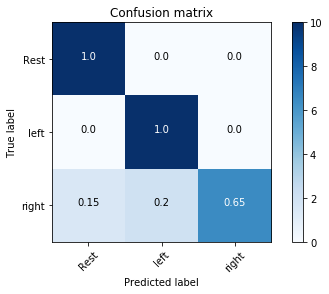

In [16]:
from sklearn.naive_bayes import GaussianNB

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = GaussianNB()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

scores = []
classification_report = []
confusion_matrix = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    scores.append(svc.score(X_test, test_list[i]['Y_test']))
    classification_report.append(metrics.classification_report(test_list[i]['Y_test'], svc.predict(X_test)))
    confusion_matrix.append(metrics.confusion_matrix(test_list[i]['Y_test'],svc.predict(X_test)))

print "MAX:", np.max(scores)
print "MEAN:", np.mean(scores)
print "MIN:", np.min(scores)
print "DISP:", np.std(scores)
print classification_report[0]

plot_mult_conf_matrices(confusion_matrix,[u'Rest',u'left',u'right'])

## K-nearest neighbours

MAX: 0.966666666667
MEAN: 0.866666666667
MIN: 0.766666666667
DISP: 0.0561083607687
             precision    recall  f1-score   support

          1       0.91      1.00      0.95        10
          2       0.82      0.90      0.86        10
          3       1.00      0.80      0.89        10

avg / total       0.91      0.90      0.90        30

Normalized confusion matrix


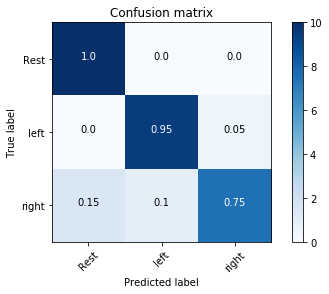

In [17]:
from sklearn.neighbors import KNeighborsClassifier

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = KNeighborsClassifier()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

scores = []
classification_report = []
confusion_matrix = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    scores.append(svc.score(X_test, test_list[i]['Y_test']))
    classification_report.append(metrics.classification_report(test_list[i]['Y_test'], svc.predict(X_test)))
    confusion_matrix.append(metrics.confusion_matrix(test_list[i]['Y_test'],svc.predict(X_test)))

print "MAX:", np.max(scores)
print "MEAN:", np.mean(scores)
print "MIN:", np.min(scores)
print "DISP:", np.std(scores)
print classification_report[0]

plot_mult_conf_matrices(confusion_matrix,[u'Rest',u'left',u'right'])

## Classification and Regression Trees

MAX: 0.933333333333
MEAN: 0.786111111111
MIN: 0.6
DISP: 0.0957024065386
             precision    recall  f1-score   support

          1       0.67      1.00      0.80        10
          2       0.78      0.70      0.74        10
          3       1.00      0.60      0.75        10

avg / total       0.81      0.77      0.76        30

Normalized confusion matrix


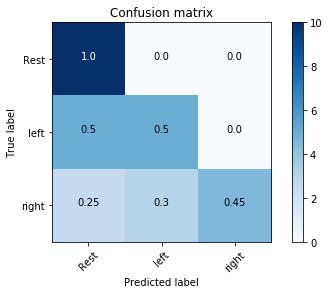

In [18]:
from sklearn.tree import DecisionTreeClassifier

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = DecisionTreeClassifier()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

scores = []
classification_report = []
confusion_matrix = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    scores.append(svc.score(X_test, test_list[i]['Y_test']))
    classification_report.append(metrics.classification_report(test_list[i]['Y_test'], svc.predict(X_test)))
    confusion_matrix.append(metrics.confusion_matrix(test_list[i]['Y_test'],svc.predict(X_test)))

print "MAX:", np.max(scores)
print "MEAN:", np.mean(scores)
print "MIN:", np.min(scores)
print "DISP:", np.std(scores)
print classification_report[0]

plot_mult_conf_matrices(confusion_matrix,[u'Rest',u'left',u'right'])

## SVM (Support Vector Machines)

MAX: 1.0
MEAN: 0.844444444444
MIN: 0.666666666667
DISP: 0.109994388185
             precision    recall  f1-score   support

          1       1.00      1.00      1.00        10
          2       0.91      1.00      0.95        10
          3       1.00      0.90      0.95        10

avg / total       0.97      0.97      0.97        30

Normalized confusion matrix


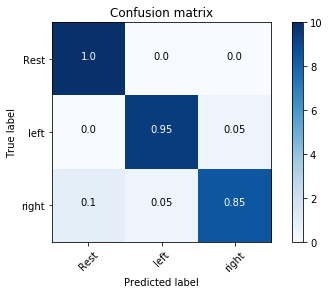

In [19]:
from sklearn.svm import SVC

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = SVC()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

scores = []
classification_report = []
confusion_matrix = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    scores.append(svc.score(X_test, test_list[i]['Y_test']))
    classification_report.append(metrics.classification_report(test_list[i]['Y_test'], svc.predict(X_test)))
    confusion_matrix.append(metrics.confusion_matrix(test_list[i]['Y_test'],svc.predict(X_test)))

print "MAX:", np.max(scores)
print "MEAN:", np.mean(scores)
print "MIN:", np.min(scores)
print "DISP:", np.std(scores)
print classification_report[0]

plot_mult_conf_matrices(confusion_matrix,[u'Rest',u'left',u'right'])

## Neural Network

MAX: 0.933333333333
MEAN: 0.783333333333
MIN: 0.6
DISP: 0.102288625775
             precision    recall  f1-score   support

          1       1.00      1.00      1.00        10
          2       0.71      1.00      0.83        10
          3       1.00      0.60      0.75        10

avg / total       0.90      0.87      0.86        30

Normalized confusion matrix


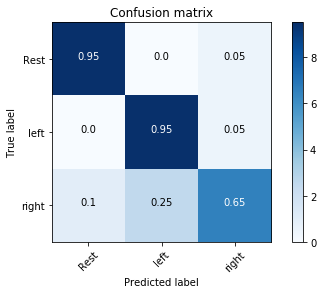

In [20]:
from sklearn.neural_network import MLPClassifier

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 15), random_state=1)
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

scores = []
classification_report = []
confusion_matrix = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    scores.append(svc.score(X_test, test_list[i]['Y_test']))
    classification_report.append(metrics.classification_report(test_list[i]['Y_test'], svc.predict(X_test)))
    confusion_matrix.append(metrics.confusion_matrix(test_list[i]['Y_test'],svc.predict(X_test)))

print "MAX:", np.max(scores)
print "MEAN:", np.mean(scores)
print "MIN:", np.min(scores)
print "DISP:", np.std(scores)
print classification_report[0]

plot_mult_conf_matrices(confusion_matrix,[u'Rest',u'left',u'right'])

## Logistic Regression

MAX: 0.966666666667
MEAN: 0.727777777778
MIN: 0.6
DISP: 0.112079116677
             precision    recall  f1-score   support

          1       1.00      1.00      1.00        10
          2       0.62      1.00      0.77        10
          3       1.00      0.40      0.57        10

avg / total       0.88      0.80      0.78        30

Normalized confusion matrix


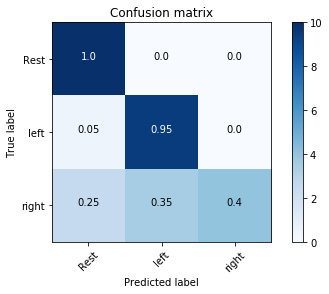

In [21]:
from sklearn.linear_model import LogisticRegression

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

scores = []
classification_report = []
confusion_matrix = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    scores.append(svc.score(X_test, test_list[i]['Y_test']))
    classification_report.append(metrics.classification_report(test_list[i]['Y_test'], svc.predict(X_test)))
    confusion_matrix.append(metrics.confusion_matrix(test_list[i]['Y_test'],svc.predict(X_test)))

print "MAX:", np.max(scores)
print "MEAN:", np.mean(scores)
print "MIN:", np.min(scores)
print "DISP:", np.std(scores)
print classification_report[0]

plot_mult_conf_matrices(confusion_matrix,[u'Rest',u'left',u'right'])

MAX: 0.966666666667
MEAN: 0.775
MIN: 0.366666666667
DISP: 0.165061716853
             precision    recall  f1-score   support

          1       1.00      1.00      1.00        10
          2       0.77      1.00      0.87        10
          3       1.00      0.70      0.82        10

avg / total       0.92      0.90      0.90        30

Normalized confusion matrix


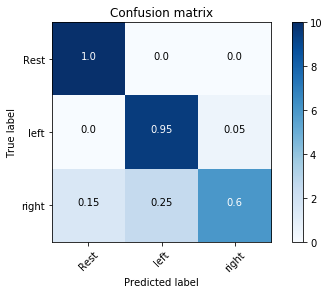

In [22]:
from skrvm import RVC

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = RVC(alpha=1e-06, beta=1e-06, beta_fixed=False, bias_used=True, coef0=0.0,
coef1=None, degree=3, kernel='rbf', n_iter=3000, n_iter_posterior=50,
threshold_alpha=1000000000.0, tol=0.001, verbose=False)
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

scores = []
classification_report = []
confusion_matrix = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    scores.append(svc.score(X_test, test_list[i]['Y_test']))
    classification_report.append(metrics.classification_report(test_list[i]['Y_test'], svc.predict(X_test)))
    confusion_matrix.append(metrics.confusion_matrix(test_list[i]['Y_test'],svc.predict(X_test)))

print "MAX:", np.max(scores)
print "MEAN:", np.mean(scores)
print "MIN:", np.min(scores)
print "DISP:", np.std(scores)
print classification_report[0]

plot_mult_conf_matrices(confusion_matrix,[u'Rest',u'left',u'right'])